# Semi Synthetic Experiments

Analyze the performance of various algorithms to solve the joint matching + activity task, when the number of volunteers is large and structured

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import json 
import argparse 
import sys
import secrets

In [248]:
from rmab.simulator import RMABSimulator
from rmab.omniscient_policies import *
from rmab.fr_dynamics import get_all_transitions
from rmab.mcts_policies import *
from rmab.utils import get_save_path, delete_duplicate_results, create_prob_distro
import resource

In [10]:
torch.cuda.set_per_process_memory_fraction(0.5)
torch.set_num_threads(1)
resource.setrlimit(resource.RLIMIT_AS, (30 * 1024 * 1024 * 1024, -1))

In [11]:
is_jupyter = 'ipykernel' in sys.modules

In [225]:
if is_jupyter: 
    seed        = 42
    n_arms      = 4
    volunteers_per_arm = 2
    budget      = 2
    discount    = 0.9
    alpha       = 3 
    n_episodes  = 200
    episode_len = 20 
    n_epochs    = 1 
    save_with_date = False 
    TIME_PER_RUN = 0.01 * 1000
    lamb = 0.5
    prob_distro = 'uniform'
    policy_lr=5e-3
    value_lr=1e-4
    train_iterations = 30
    test_iterations = 30
    out_folder = 'mcts_exploration/rl_exploration'
else:
    parser = argparse.ArgumentParser()
    parser.add_argument('--n_arms',         '-N', help='num beneficiaries (arms)', type=int, default=2)
    parser.add_argument('--volunteers_per_arm',         '-V', help='volunteers per arm', type=int, default=5)
    parser.add_argument('--episode_len',    '-H', help='episode length', type=int, default=20)
    parser.add_argument('--n_episodes',     '-T', help='num episodes', type=int, default=800)
    parser.add_argument('--budget',         '-B', help='budget', type=int, default=3)
    parser.add_argument('--n_epochs',       '-E', help='number of epochs (num_repeats)', type=int, default=1)
    parser.add_argument('--discount',       '-d', help='discount factor', type=float, default=0.9)
    parser.add_argument('--alpha',          '-a', help='alpha: for conf radius', type=float, default=3)
    parser.add_argument('--lamb',          '-l', help='lambda for matching-engagement tradeoff', type=float, default=0.5)
    parser.add_argument('--seed',           '-s', help='random seed', type=int, default=42)
    parser.add_argument('--prob_distro',           '-p', help='which prob distro [uniform,uniform_small,uniform_large,normal]', type=str, default='uniform')
    parser.add_argument('--time_per_run',      '-t', help='time per MCTS run', type=float, default=.01*1000)
    parser.add_argument('--policy_lr', help='Learning Rate Policy', type=float, default=5e-3)
    parser.add_argument('--value_lr', help='Learning Rate Value', type=float, default=1e-4)
    parser.add_argument('--train_iterations', help='Number of MCTS train iterations', type=int, default=30)
    parser.add_argument('--test_iterations', help='Number of MCTS test iterations', type=int, default=30)
    parser.add_argument('--out_folder', help='Which folder to write results to', type=str, default='mcts_exploration/rl_exploration')

    parser.add_argument('--use_date', action='store_true')

    args = parser.parse_args()

    n_arms      = args.n_arms
    volunteers_per_arm = args.volunteers_per_arm
    budget      = args.budget
    discount    = args.discount
    alpha       = args.alpha 
    seed        = args.seed
    n_episodes  = args.n_episodes
    episode_len = args.episode_len
    n_epochs    = args.n_epochs
    lamb = args.lamb
    save_with_date = args.use_date
    TIME_PER_RUN = args.time_per_run
    prob_distro = args.prob_distro
    policy_lr = args.policy_lr 
    value_lr = args.value_lr 
    out_folder = args.out_folder
    train_iterations = args.train_iterations 
    test_iterations = args.test_iterations 

save_name = secrets.token_hex(4)  

In [226]:
n_states = 2
n_actions = 2

In [227]:
all_population_size = 100 # number of random arms to generate
all_transitions = get_all_transitions(all_population_size)

In [228]:
# min_transition_value = 0.5
# for i in range(len(all_transitions)):
#     for j in range(2):
#         for k in range(2):
#             if all_transitions[i,j,k,0] >  all_transitions[i,j,k,1]:
#                 all_transitions[i,j,k,0] = (random.random())*(1-min_transition_value) + min_transition_value
#             else:
#                 all_transitions[i,j,k,0] = 1-((random.random())*(1-min_transition_value) + min_transition_value)
            
#             all_transitions[i,j,k,1] = 1-all_transitions[i,j,k,0]  


In [229]:
def create_environment(seed):
    random.seed(seed)
    np.random.seed(seed)

    if prob_distro == 'uniform':
        match_probabilities = [np.random.random() for i in range(all_population_size * volunteers_per_arm)] 
    elif prob_distro == 'uniform_small':
        match_probabilities = [np.random.random()/4 for i in range(all_population_size * volunteers_per_arm)] 
    elif prob_distro == 'uniform_large':
        match_probabilities = [np.random.random()/4+0.75 for i in range(all_population_size * volunteers_per_arm)] 
    elif prob_distro == 'normal':
        match_probabilities = [np.clip(np.random.normal(0.25, 0.1),0,1) for i in range(all_population_size * volunteers_per_arm)] 

    all_features = np.arange(all_population_size)
    match_probabilities = create_prob_distro(prob_distro,all_population_size*volunteers_per_arm)
    simulator = RMABSimulator(all_population_size, all_features, all_transitions,
                n_arms, volunteers_per_arm, episode_len, n_epochs, n_episodes, budget, discount,number_states=n_states, reward_style='match',match_probability_list=match_probabilities,TIME_PER_RUN=TIME_PER_RUN)

    return simulator 

In [230]:
def run_multi_seed(seed_list,policy,is_mcts=False,per_epoch_function=None,train_iterations=0,test_iterations=0,test_length=500):
    memories = []
    scores = {
        'reward': [],
        'time': [], 
        'match': [], 
        'active_rate': [],
    }

    for seed in seed_list:
        simulator = create_environment(seed)
        if is_mcts:
            simulator.mcts_train_iterations = train_iterations
            simulator.mcts_test_iterations = test_iterations
            simulator.policy_lr = policy_lr
            simulator.value_lr = value_lr

        if is_mcts:
            match, active_rate, memory = run_heterogenous_policy(simulator, n_episodes, n_epochs, discount,policy,seed,lamb=lamb,should_train=True,test_T=test_length,get_memory=True,per_epoch_function=per_epoch_function)
        else:
            match, active_rate = run_heterogenous_policy(simulator, n_episodes, n_epochs, discount,policy,seed,lamb=lamb,should_train=True,test_T=test_length,per_epoch_function=per_epoch_function)
        time_whittle = simulator.time_taken
        discounted_reward = get_discounted_reward(match,active_rate,discount,lamb)
        scores['reward'].append(discounted_reward)
        scores['time'].append(time_whittle)
        scores['match'].append(np.mean(match))
        scores['active_rate'].append(np.mean(active_rate))
        if is_mcts:
            memories.append(memory)

    return scores, memories, simulator

In [231]:
results = {}
results['parameters'] = {'seed'      : seed,
        'n_arms'    : n_arms,
        'volunteers_per_arm': volunteers_per_arm, 
        'budget'    : budget,
        'discount'  : discount, 
        'alpha'     : alpha, 
        'n_episodes': n_episodes, 
        'episode_len': episode_len, 
        'n_epochs'  : n_epochs, 
        'lamb': lamb,
        'time_per_run': TIME_PER_RUN, 
        'prob_distro': prob_distro, 
        'policy_lr': policy_lr, 
        'value_lr': value_lr} 

## Index Policies

In [232]:
seed_list = [43]

In [239]:
policy = whittle_policy
name = "linear_whittle"

rewards, memory, simulator = run_multi_seed(seed_list,policy)
results['{}_reward'.format(name)] = rewards['reward']
results['{}_match'.format(name)] =  rewards['match'] 
results['{}_active'.format(name)] = rewards['active_rate']
results['{}_time'.format(name)] =  rewards['time']
print(np.mean(rewards['reward']))

acting should always be good! 0.000 < 0.044
acting should always be good! 0.000 < 0.162
acting should always be good! 0.108 < 0.183
good start state should always be good! 0.380 < 0.508
good start state should always be good! 0.506 < 0.760
cohort [26 66 85 81]
instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
instance 0, ep 30
instance 0, ep 31
instance 0, ep 32
instance 0, ep 33
instance 0, ep 34
instance 0, ep 35
instance 0, ep 36
instance 0, ep 37
instance 0, ep 38
instance 0, ep 39
instance 0, ep 40
instance 0, ep 41
instance 0

In [243]:
if n_arms * volunteers_per_arm <= 4:
    policy = q_iteration_policy
    per_epoch_function = q_iteration_epoch
    name = "optimal"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,per_epoch_function=per_epoch_function)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    print(np.mean(rewards['reward']))

In [244]:
if n_arms * volunteers_per_arm <= 10:
    policy = dqn_policy
    name = "dqn"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,is_mcts=True)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    print(np.mean(rewards['reward']))

acting should always be good! 0.000 < 0.044
acting should always be good! 0.000 < 0.162
acting should always be good! 0.108 < 0.183
good start state should always be good! 0.380 < 0.508
good start state should always be good! 0.506 < 0.760
cohort [26 66 85 81]
instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
instance 0, ep 30
instance 0, ep 31
instance 0, ep 32
instance 0, ep 33
instance 0, ep 34
instance 0, ep 35
instance 0, ep 36
instance 0, ep 37
instance 0, ep 38
instance 0, ep 39
instance 0, ep 40
instance 0, ep 41
instance 0

In [245]:
if n_arms * volunteers_per_arm <= 10:
    policy = dqn_stable_policy
    name = "dqn"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,is_mcts=True)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    print(np.mean(rewards['reward']))

acting should always be good! 0.000 < 0.044
acting should always be good! 0.000 < 0.162
acting should always be good! 0.108 < 0.183
good start state should always be good! 0.380 < 0.508
good start state should always be good! 0.506 < 0.760
cohort [26 66 85 81]
instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
instance 0, ep 30
instance 0, ep 31
instance 0, ep 32
instance 0, ep 33
instance 0, ep 34
instance 0, ep 35
instance 0, ep 36
instance 0, ep 37
instance 0, ep 38
instance 0, ep 39
instance 0, ep 40
instance 0, ep 41
instance 0

In [246]:
policy = dqn_with_steps
name = "dqn_step"

rewards, memory, simulator = run_multi_seed(seed_list,policy,is_mcts=True)
results['{}_reward'.format(name)] = rewards['reward']
results['{}_match'.format(name)] =  rewards['match'] 
results['{}_active'.format(name)] = rewards['active_rate']
results['{}_time'.format(name)] =  rewards['time']
print(np.mean(rewards['reward']))

acting should always be good! 0.000 < 0.044
acting should always be good! 0.000 < 0.162
acting should always be good! 0.108 < 0.183
good start state should always be good! 0.380 < 0.508
good start state should always be good! 0.506 < 0.760
cohort [26 66 85 81]
instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
instance 0, ep 30
instance 0, ep 31
instance 0, ep 32
instance 0, ep 33
instance 0, ep 34
instance 0, ep 35
instance 0, ep 36
instance 0, ep 37
instance 0, ep 38
instance 0, ep 39
instance 0, ep 40
instance 0, ep 41
instance 0

In [234]:
def plot_sliding_window(data):
    return [np.mean(data[i:i+100]) for i in range(len(data)-100)]
value_loss_1 = memory[0][3]
past_rewards = memory[0][2]
avg_reward = [i for i in memory[0][-1]]

In [235]:
results['avg_reward'] = [float(i) for i in avg_reward]

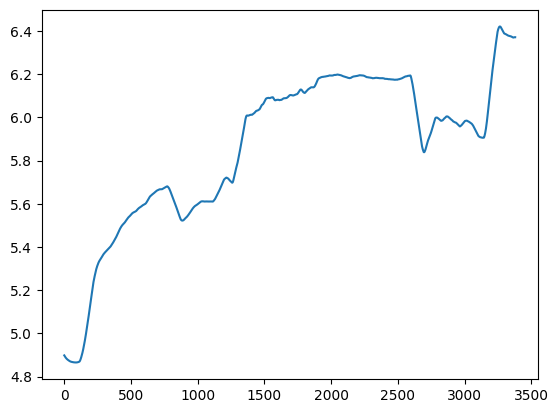

In [236]:
if is_jupyter:  
    plt.plot(plot_sliding_window(avg_reward))

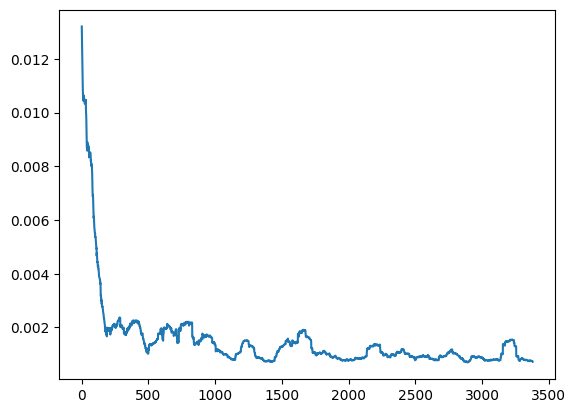

In [237]:
if is_jupyter:  
    plt.plot(plot_sliding_window(value_loss_1))

In [238]:
if n_arms * volunteers_per_arm <= 10:
    errors = []
    value_network = memory[-1][4]

    N = volunteers_per_arm*n_arms 
    q_vals = []
    for s in range(2**(volunteers_per_arm*n_arms)):
        state = [int(j) for j in bin(s)[2:].zfill(N)]
        pred_q_val = torch.max(value_network(torch.Tensor([state]))).item()
        q_vals.append(pred_q_val)
    print(np.std(q_vals))

0.21322965070839323


In [197]:
if n_arms * volunteers_per_arm <= 4:
    errors = []
    value_network = memory[-1][4]

    match_probability = simulator.match_probability_list 
    if match_probability != []:
        match_probability = np.array(match_probability)[simulator.agent_idx]
    true_transitions = simulator.transitions
    discount = simulator.discount 
    budget = simulator.budget 
    Q_vals = arm_value_iteration_exponential(true_transitions,discount,budget,simulator.volunteers_per_arm,
                    reward_function='combined',lamb=lamb,
                    match_probability_list=match_probability)

    N = volunteers_per_arm*n_arms 
    error_max_action = []
    error_overall = []
    for s in range(2**(volunteers_per_arm*n_arms)):
        state = [int(j) for j in bin(s)[2:].zfill(N)]
        max_q_val = np.max(Q_vals[s])
        max_action = np.argmax(Q_vals[s])
        action = [int(j) for j in bin(max_action)[2:].zfill(N)]
        pred_q_val = torch.max(value_network(torch.Tensor([state]))).item()
        errors.append((pred_q_val-max_q_val))
    results["q_val_errors"] = [float(i) for i in errors]
[float(i) for i in errors], np.mean([abs(float(i)) for i in errors]), np.std([float(i) for i in errors])

/tmp/ipykernel_10587/1654070364.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if match_probability != []:


([-0.019691974889837205,
  -0.018671948504272784,
  -0.019140385684310424,
  -0.025606058500033058,
  -0.016741028099565902,
  -0.017053394943331135,
  -0.01806141268892958,
  -0.019326440621977525,
  -0.01727142511110369,
  -0.01746646697082266,
  -0.017470760650454054,
  -0.015208601813033518,
  -0.01884551293130521,
  -0.014998862934198165,
  -0.017792495629510796,
  -0.013526768446121551],
 0.017929596151175453,
 0.002565320776945335)

In [126]:
np.mean(value_loss_1[-100:])

0.022583837546408178

In [133]:
avg_error = {}
std_error = {}
avg_loss = {}
diff_optimal = {}
for min_transition_value in [0.5,0.75,0.9,0.99]:
    for i in range(len(all_transitions)):
        for j in range(2):
            for k in range(2):
                if all_transitions[i,j,k,0] >  all_transitions[i,j,k,1]:
                    all_transitions[i,j,k,0] = (random.random())*(1-min_transition_value) + min_transition_value
                else:
                    all_transitions[i,j,k,0] = 1-((random.random())*(1-min_transition_value) + min_transition_value)
                
                all_transitions[i,j,k,1] = 1-all_transitions[i,j,k,0]  
    policy = q_iteration_policy
    per_epoch_function = q_iteration_epoch

    rewards, memory, simulator = run_multi_seed(seed_list,policy,per_epoch_function=per_epoch_function)
    optimal_reward = rewards['reward']

    policy = dqn_policy
    rewards, memory, simulator = run_multi_seed(seed_list,policy,is_mcts=True)
    dqn_reward = rewards['reward']
    diff_optimal[min_transition_value] = np.mean(optimal_reward) - np.mean(dqn_reward)
    
    losses = []

    for i in range(3):
        value_loss_1 = memory[i][3]
        losses.append(np.mean(value_loss_1[-100:]))
    avg_loss[min_transition_value] = np.mean(losses)

    all_errors = []

    for i in range(3):
        errors = []
        value_network = memory[0][4]
        match_probability = simulator.match_probability_list 
        if match_probability != []:
            match_probability = np.array(match_probability)[simulator.agent_idx]
        true_transitions = simulator.transitions
        discount = simulator.discount 
        budget = simulator.budget 
        Q_vals = arm_value_iteration_exponential(true_transitions,discount,budget,simulator.volunteers_per_arm,
                        reward_function='combined',lamb=lamb,
                        match_probability_list=match_probability)

        N = volunteers_per_arm*n_arms 
        error_max_action = []
        error_overall = []
        for s in range(2**(volunteers_per_arm*n_arms)):
            state = [int(j) for j in bin(s)[2:].zfill(N)]
            max_q_val = np.max(Q_vals[s])
            max_action = np.argmax(Q_vals[s])
            action = [int(j) for j in bin(max_action)[2:].zfill(N)]
            pred_q_val = torch.max(value_network(torch.Tensor([state]))).item()
            errors.append((pred_q_val-max_q_val))
        q_val_errors = [float(i) for i in errors]
        all_errors.append(q_val_errors)
    avg_error[min_transition_value] = np.mean(all_errors)
    std_error[min_transition_value] = np.std(all_errors)

    print("Avg error {}".format(avg_error))
    print("Std error {}".format(std_error))
    print("avg_loss {} ".format(avg_loss))
    print("Diff optimal {}".format(diff_optimal))



acting should always be good! 0.247 < 0.408
acting should always be good! 0.196 < 0.444
acting should always be good! 0.115 < 0.230
acting should always be good! 0.117 < 0.265
acting should always be good! 0.052 < 0.500
acting should always be good! 0.018 < 0.418
acting should always be good! 0.294 < 0.443
acting should always be good! 0.072 < 0.122
acting should always be good! 0.313 < 0.337
acting should always be good! 0.041 < 0.179
acting should always be good! 0.408 < 0.492
acting should always be good! 0.036 < 0.194
acting should always be good! 0.096 < 0.360
acting should always be good! 0.113 < 0.438
acting should always be good! 0.012 < 0.161
acting should always be good! 0.062 < 0.162
acting should always be good! 0.015 < 0.217
acting should always be good! 0.191 < 0.427
acting should always be good! 0.107 < 0.230
acting should always be good! 0.558 < 0.604
acting should always be good! 0.388 < 0.443
acting should always be good! 0.427 < 0.429
acting should always be good! 0.

/tmp/ipykernel_2673384/3867224635.py:39: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if match_probability != []:


Avg error {0.5: -0.884179274065979}
Std error {0.5: 0.12533294692972805}
avg_loss {0.5: 0.028429649863392113} 
Diff optimal {0.5: 0.034869077170008644}
acting should always be good! 0.054 < 0.081
acting should always be good! 0.088 < 0.100
acting should always be good! 0.013 < 0.135
acting should always be good! 0.073 < 0.079
acting should always be good! 0.228 < 0.229
acting should always be good! 0.007 < 0.223
acting should always be good! 0.096 < 0.191
acting should always be good! 0.123 < 0.204
acting should always be good! 0.009 < 0.209
acting should always be good! 0.147 < 0.222
acting should always be good! 0.021 < 0.089
acting should always be good! 0.204 < 0.246
acting should always be good! 0.018 < 0.097
acting should always be good! 0.048 < 0.180
acting should always be good! 0.006 < 0.080
acting should always be good! 0.825 < 0.863
acting should always be good! 0.008 < 0.108
acting should always be good! 0.834 < 0.987
acting should always be good! 0.054 < 0.074
acting shoul

In [135]:
avg_error

{0.5: -0.884179274065979,
 0.75: -1.437454841799361,
 0.9: -1.6646107245991948,
 0.99: -1.4968099684917406}

In [138]:
std_error

{0.5: 0.12533294692972805,
 0.75: 0.2421711001169778,
 0.9: 0.18380619724809416,
 0.99: 0.22811253392025485}

In [136]:
diff_optimal

{0.5: 0.034869077170008644,
 0.75: 0.02930044005542598,
 0.9: 0.33705622149300574,
 0.99: 0.0006235983577953519}

/tmp/ipykernel_2673384/1792193072.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if match_probability != []:


## Write Data

In [34]:
save_path = get_save_path(out_folder,save_name,seed,use_date=save_with_date)

In [40]:
delete_duplicate_results(out_folder,"",results)

In [41]:
json.dump(results,open('../../results/'+save_path,'w'))